Paper Source

"Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts"

https://arxiv.org/abs/2108.09004


In [1]:
!pip install qiskit[visualization]

# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np

# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt

# IBMQ.save_account('Put your token')
# provider = IBMQ.load_account()
# IBMQ.get_provider(hub='ibm-q', group='open', project = 'main')

You should consider upgrading via the 'c:\users\m\appdata\local\conda\conda\envs\qiskit-ionq-2\python.exe -m pip install --upgrade pip' command.


C:\Users\m\AppData\Local\conda\conda\envs\braket\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


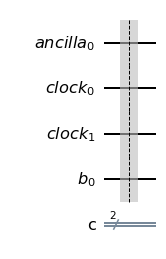

In [30]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [31]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cu1(-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cu1(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [32]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circuit.barrier()

In [33]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [34]:
# State preparation. (various initial values)
# (restart from second cell if changed)

intial_state = [0,1]
#intial_state = [1,0]
# intial_state = [1/np.sqrt(2),1/np.sqrt(2)]
# intial_state = [np.sqrt(0.9),np.sqrt(0.1)]

circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


circuit.measure(input, measurement[1])

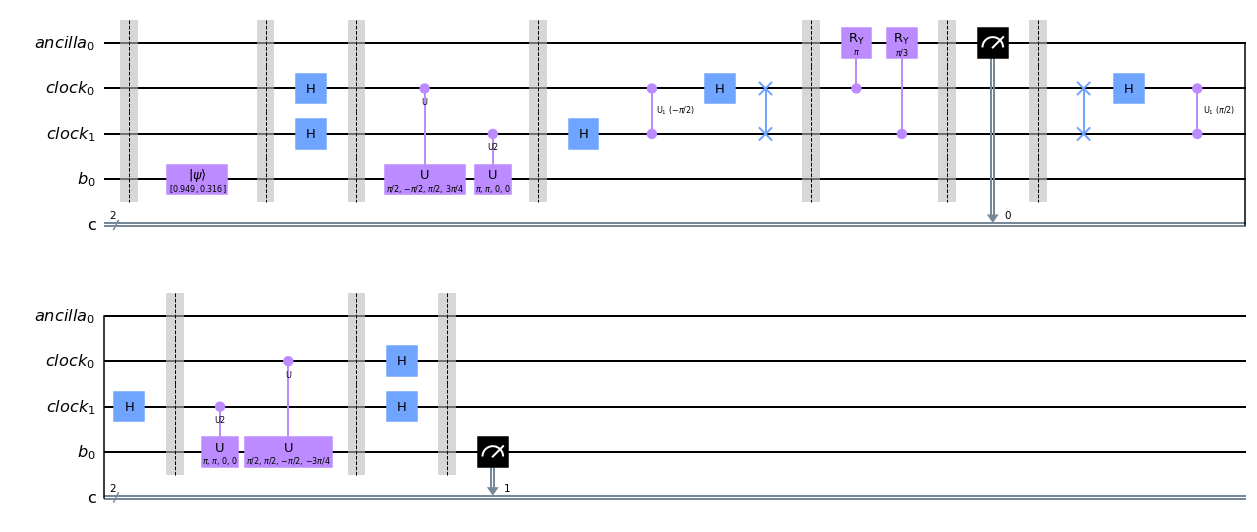

In [35]:
circuit.draw('mpl',scale=1)
#print(circuit)

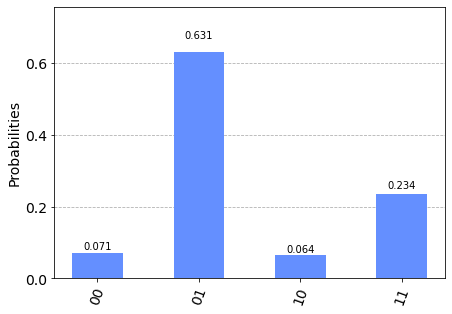

In [36]:
# Execute the circuit using the simulator
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=1000)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)

In [9]:
bcknd = Aer.get_backend('statevector_simulator')

job_sim = execute(circuit, bcknd)
result = job_sim.result()

o_state_result = result.get_statevector(circuit, decimals=3)
print(o_state_result)

[ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]


In [10]:
provider.backends()

# Choose the backend on which to run the circuit
backend = provider.get_backend('ibmq_santiago')

from qiskit.tools.monitor import job_monitor

# Execute the job
job_exp = execute(circuit, backend=backend, shots=8192)

# Monitor the job to know where we are in the queue
job_monitor(job_exp, interval = 2)

NameError: name 'provider' is not defined

In [11]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(circuit)

# Plot the results
plot_histogram(answer)

NameError: name 'job_exp' is not defined

Total counts are: {'0001': 65, '1001': 561, '0000': 206, '1000': 168}
                           ░       ░               ░                         »
q80_0: ────────────────────░───────░───────────────░─────────────────────────»
                           ░ ┌───┐ ░ ┌────┐        ░                    ┌───┐»
q80_1: ────────────────────░─┤ H ├─░─┤0   ├────────░───────■────────────┤ H ├»
                           ░ ├───┤ ░ │    │┌─────┐ ░ ┌───┐ │U1(-1.5708) └───┘»
q80_2: ────────────────────░─┤ H ├─░─┤  U ├┤0    ├─░─┤ H ├─■─────────────────»
       ┌─────────────────┐ ░ └───┘ ░ │    ││  U2 │ ░ └───┘                   »
q80_3: ┤ initialize(0,1) ├─░───────░─┤1   ├┤1    ├─░─────────────────────────»
       └─────────────────┘ ░       ░ └────┘└─────┘ ░                         »
 c0: 4/══════════════════════════════════════════════════════════════════════»
                                                                             »
«           ░ ┌───────┐┌──────────┐ ░                        

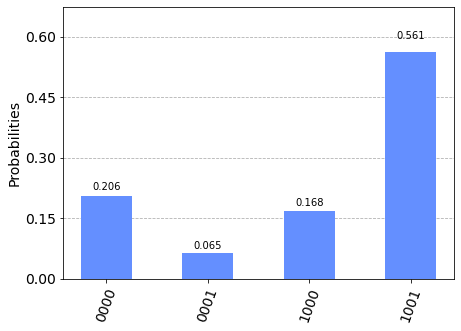

In [12]:
# Auto generated circuit (almost) matching the form from the Wong paper (using cu gates)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

beta = 0
cycle_time = 0.5

qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr, cr, name="main")

intial_state = [0,1]
qc.initialize(intial_state, qr[3])

qc.barrier(qr[0], qr[1], qr[2], qr[3])

qc.h(qr[1])
qc.h(qr[2])

qc.barrier(qr[0], qr[1], qr[2], qr[3])

# e^{i*A*t}
qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, qr[1], qr[3], label='U');

# e^{i*A*t*2}
qc.cu(np.pi, np.pi, 0, 0, qr[2], qr[3], label='U2');

qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.h(qr[2])
qc.cu1(-3.14159/2, qr[1], qr[2])
qc.h(qr[1])
qc.swap(qr[2], qr[1])
qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.cry(3.14159, qr[1], qr[0])
qc.cry(3.14159/3, qr[2], qr[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.swap(qr[2], qr[1])
qc.h(qr[1])
qc.cu1(3.14159/2, qr[1], qr[2])
qc.h(qr[2])
qc.barrier(qr[0], qr[1], qr[2], qr[3])

# e^{i*A*t*2}
qc.cu(np.pi, np.pi, 0, 0, qr[2], qr[3], label='U2');

# e^{i*A*t}
qc.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, qr[1], qr[3], label='U');

qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.h(qr[1])
qc.h(qr[2])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.measure(qr[0], cr[0])
qc.measure(qr[3], cr[3])

from qiskit import execute, Aer
backend = Aer.get_backend("qasm_simulator")  # Use Aer qasm_simulator

job = execute(qc, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc)
print("Total counts are:", counts)

# Draw the circuit
print(qc)
#qc.draw('mpl',scale=1)

# Plot a histogram
from qiskit.visualization import plot_histogram
plot_histogram(counts)


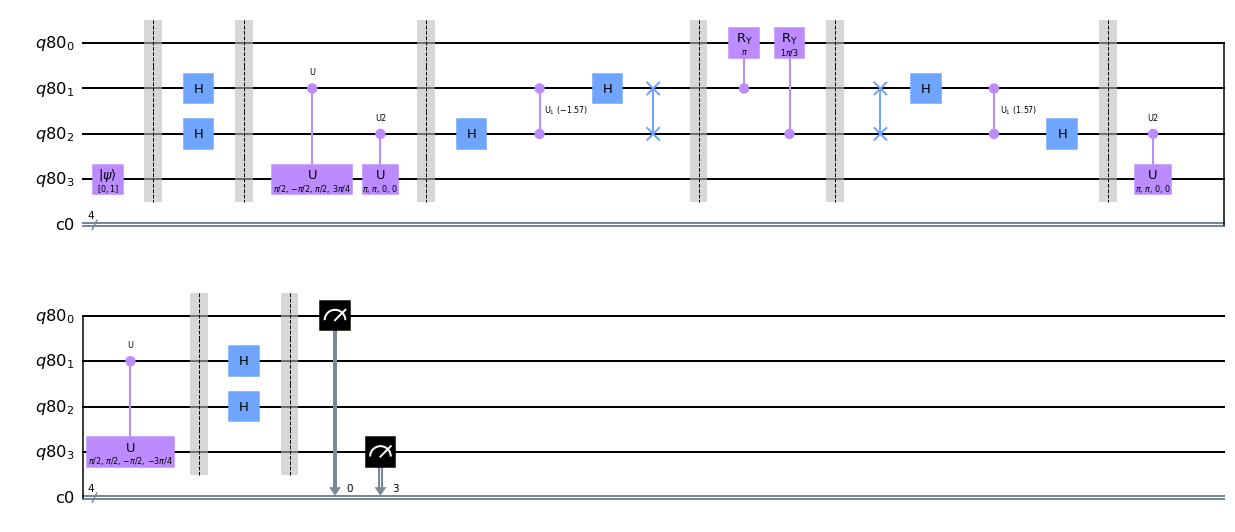

In [13]:
qc.draw('mpl',scale=1)


<ipython-input-14-1ad3cc41a804>:26: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  qc.cu3(3.14159/2, -3.14159/2, 3.14159/2, qr[1], qr[3])


Total counts are: {'0001': 70, '1001': 553, '0000': 178, '1000': 199}
                  ░       ░                                           »
q127_0: ──────────░───────░───────────────────────────────────────────»
                  ░ ┌───┐ ░                                           »
q127_1: ──────────░─┤ H ├─░──■─────────────────────────■──────────────»
                  ░ ├───┤ ░  │                         │              »
q127_2: ──────────░─┤ H ├─░──┼─────────────────────────┼──────────────»
        ┌───────┐ ░ └───┘ ░  │U1(2.3562) ┌─────────────┴─────────────┐»
q127_3: ┤ RY(π) ├─░───────░──■───────────┤ U3(1.5708,-1.5708,1.5708) ├»
        └───────┘ ░       ░              └───────────────────────────┘»
  c1: 4/══════════════════════════════════════════════════════════════»
                                                                      »
«                      ░                             ░ ┌───────┐┌──────────┐ ░ »
«q127_0: ──────────────░─────────────────────────────░─┤ 

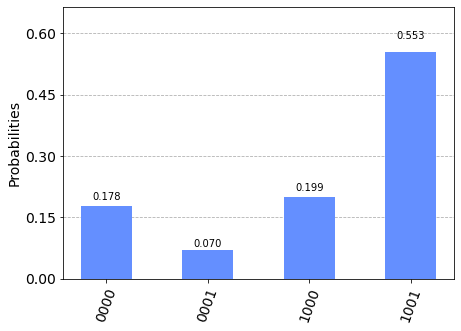

In [14]:
# Same example as above but using the U3 and U1 gates instead of U1
# Initialize with RY instead of "initialize()"

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

beta = 1
cycle_time = 0.5

qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr, cr, name="main")

# intial_state = [0,1]
# qc.initialize(intial_state, qr[3])
qc.ry(3.14159*beta, qr[3])

qc.barrier(qr[0], qr[1], qr[2], qr[3])

qc.h(qr[1])
qc.h(qr[2])
qc.barrier(qr[0], qr[1], qr[2], qr[3])

# e^{i*A*t}
# qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, qr[1], qr[3], label='U');
qc.cu1(3*3.14159/4, qr[1], qr[3])
qc.cu3(3.14159/2, -3.14159/2, 3.14159/2, qr[1], qr[3])

# e^{i*A*t*2}
# qc.cu(np.pi, np.pi, 0, 0, qr[2], qr[3], label='U2');
qc.cu3(3.14159, 3.14159, 0, qr[2], qr[3])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.h(qr[2])
qc.cu1(-3.14159/2, qr[1], qr[2])
qc.h(qr[1])
qc.swap(qr[2], qr[1])
qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.cry(3.14159, qr[1], qr[0])
qc.cry(3.14159/3, qr[2], qr[0])
qc.barrier(qr[0], qr[1], qr[2], qr[3])
qc.swap(qr[2], qr[1])
qc.h(qr[1])
qc.cu1(3.14159/2, qr[1], qr[2])
qc.h(qr[2])
qc.barrier(qr[0], qr[1], qr[2], qr[3])

# e^{i*A*t*2}
# qc.cu(np.pi, np.pi, 0, 0, qr[2], qr[3], label='U2');
qc.cu3(3.14159, 3.14159, 0, qr[2], qr[3])

# e^{i*A*t}
# qc.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, qr[1], qr[3], label='U');
qc.cu3(3.14159/2, 3.14159/2, -3.14159/2, qr[1], qr[3])
qc.cu1(-3*3.14159/4, qr[1], qr[3])

qc.barrier(qr[0], qr[1], qr[2], qr[3])

qc.h(qr[1])
qc.h(qr[2])

qc.barrier(qr[0], qr[1], qr[2], qr[3])

qc.measure(qr[0], cr[0])
qc.measure(qr[3], cr[3])
# qc.measure(qr, cr)

from qiskit import execute, Aer
backend = Aer.get_backend("qasm_simulator")  # Use Aer qasm_simulator

job = execute(qc, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc)
print("Total counts are:", counts)

# Draw the circuit
print(qc)

# Plot a histogram
from qiskit.visualization import plot_histogram
plot_histogram(counts)


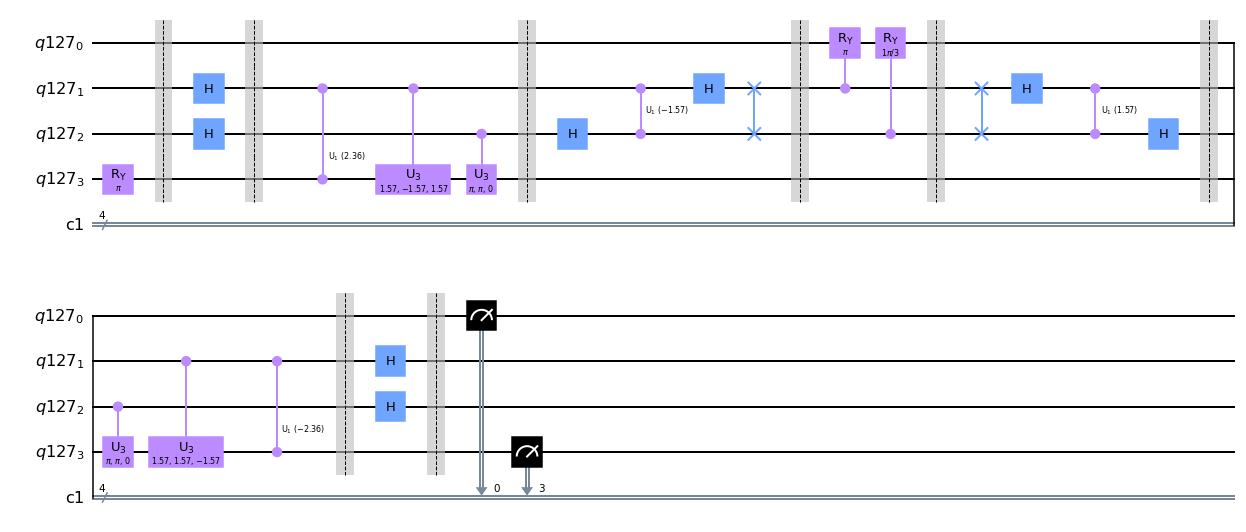

In [15]:
qc.draw('mpl',scale=1)
